In [1]:
%matplotlib inline

In [2]:
# -*- Encoding: UTF-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import datetime
import pandas as pd

from matplotlib.ticker import MultipleLocator, NullLocator

In [15]:
golden_ratio = 1.618


dir_list = ["N128_OMP16_32nodes_file_v10_1exec", 
            "N128_OMP16_32nodes_file_v10",
            "N128_OMP16_32nodes_file_v11", 
            "N128_OMP16_32nodes_file_v12",
            "N128_OMP16_32nodes_2node_v10_fast_sleep01",
            "N128_OMP16_32nodes_2node_v11_fast_sleep01",
            "N128_OMP16_32nodes_2node_v12_fast_sleep01",
            "N128_OMP16_32nodes_3node_v10",
            "N128_OMP16_32nodes_3node_v11",
            "N128_OMP16_32nodes_3node_v12"]


NMPI = 128

['INFO', '2020-05-28', '07:36:33,738,738', '[Process', '26683', 'MainProcess', 'MainThread]', '[processor_mpi_tasklist', 'main]:', 'Starting', 'run', 'ABC125']
2020-05-28 07:36:33.738738
['INFO', '2020-05-28', '07:52:09,625,625', '[Process', '27350', 'MainProcess', 'MainThread]', '[processor_mpi_tasklist', 'main]:', 'Starting', 'run', 'ABC125']
2020-05-28 07:52:09.625625
['INFO', '2020-05-28', '08:02:29,647,647', '[Process', '27849', 'MainProcess', 'MainThread]', '[processor_mpi_tasklist', 'main]:', 'Starting', 'run', 'ABC125']
2020-05-28 08:02:29.647647
['INFO', '2020-05-28', '08:14:50,009,9', '[Process', '28420', 'MainProcess', 'MainThread]', '[processor_mpi_tasklist', 'main]:', 'Starting', 'run', 'ABC125']
2020-05-28 08:14:50.009900
['INFO', '2020-05-28', '11:00:48,392,392', '[Process', '6840', 'MainProcess', 'MainThread]', '[generator', '<module>]:', 'Loading', 'h5', 'data', 'into', 'memory']
2020-05-28 11:00:48.392392
['INFO', '2020-05-28', '11:08:27,374,374', '[Process', '64659',

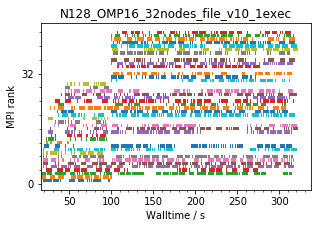

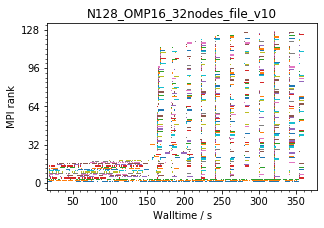

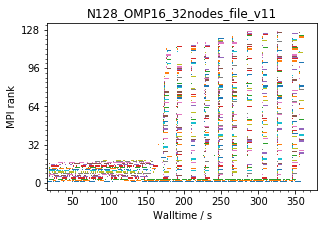

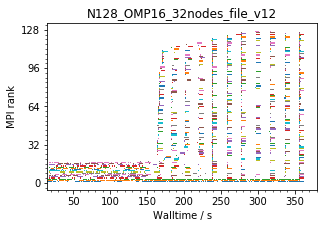

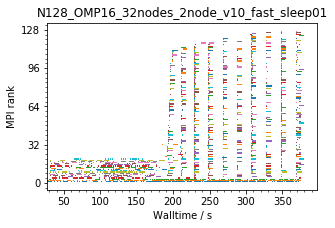

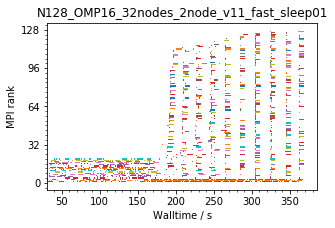

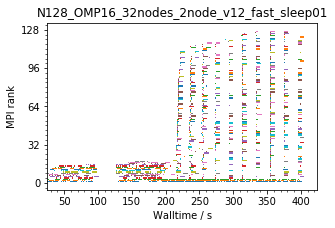

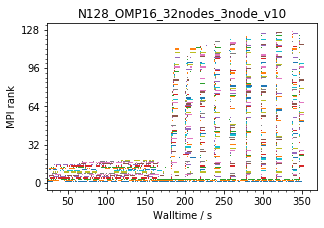

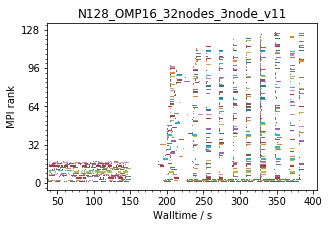

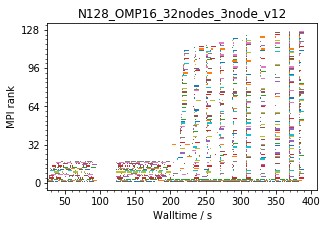

In [29]:
for rundir in dir_list:

    file_list_raw = [join("../data/tests_performance", rundir, f"outfile_{N:03d}.txt") for N in range(NMPI)]
    file_list = [f for f in file_list_raw if isfile(f)]
    file_list_raw = None

    columns = ["Name", "tidx", "node", "Start", "End"]
    dframe = pd.DataFrame(columns=columns)

    for foo in file_list:
        # Grab node from file name
        node = int(foo[-7:-4])
        with open(foo, "r") as df:
            for line in df.readlines():
                splits = line.split()
                tidx = int(splits[2][5:])
                name = splits[3]
                tstart = datetime.datetime.strptime(splits[5] + " " + splits[6], "%Y-%m-%d %H:%M:%S.%f")
                tend = datetime.datetime.strptime(splits[8] + " " + splits[9], "%Y-%m-%d %H:%M:%S.%f")

                new_row = {"Name": name, "tidx":tidx, "node": node, "Start": tstart, "End": tend}
                dframe = dframe.append(new_row, ignore_index=True)
                
    with open(join("../data/tests_performance", rundir, "delta.log"), "r") as lf:
        l0 = lf.readline()
        splits = l0.split()
        print(splits)
        # There is a , that needs to be removed
        fix_mus = splits[2].replace(",", ".", 1)
        fix_mus = fix_mus.replace(",", "")
        toff = datetime.datetime.strptime(splits[1] + " " + fix_mus, "%Y-%m-%d %H:%M:%S.%f") 
        print(toff)
    
    fig = plt.figure(figsize=(5, 5 / golden_ratio))
    ax = fig.add_axes([0.2, 0.2, 0.75, 0.75])

    for rank in range(1, NMPI):
        delta_start = dframe[dframe["node"] == rank]["Start"] - toff
        delta_end = dframe[dframe["node"] == rank]["End"] - toff

        tic = np.array([r.seconds for r in delta_start])
        toc = np.array([r.seconds for r in delta_end]) + 0.1

        ax.barh(width=toc-tic, height=1.0, y=[rank] * len(tic), left=tic)

        ax.set_ylabel("MPI rank")
        ax.set_xlabel(r"Walltime / s")
        ax.set_title(rundir)

        ax.xaxis.set_major_locator(MultipleLocator(50.0))
        ax.xaxis.set_minor_locator(MultipleLocator(10.0))
        ax.yaxis.set_major_locator(MultipleLocator(32.0))
        ax.yaxis.set_minor_locator(MultipleLocator(4.0))

        
    fig.savefig(f"{rundir}_mpirank_utilization.png")

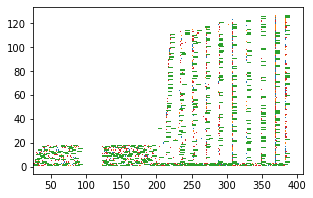

In [49]:
fig = plt.figure(figsize=(5, 5 / golden_ratio))
ax = fig.add_axes([0.2, 0.2, 0.75, 0.75])

for rank in range(1, 128):
    dframe_node = dframe.loc[dframe["node"] == rank]

    for name, C in zip(["cross_phase", "cross_power", "cross_correlation", "coherence"],
                       ["C0", "C1", "C2", "C3"]):
        dframe_sub = dframe_node.loc[dframe["Name"] == name]
        
#         print(name, rank)
#         print(dframe_sub)
        
        delta_start = dframe_sub["Start"] - toff
        delta_end = dframe_sub["End"] - toff

        tic = np.array([r.seconds for r in delta_start])
        toc = np.array([r.seconds for r in delta_end]) + 0.1

        ax.barh(width=toc-tic, height=1.0, y=[rank] * len(tic), left=tic, color=C)
        
        

#         ax.set_ylabel("MPI rank")
#         ax.set_xlabel(r"Walltime / s")
#         ax.set_title(rundir)

#         ax.xaxis.set_major_locator(MultipleLocator(50.0))
#         ax.xaxis.set_minor_locator(MultipleLocator(10.0))
#         ax.yaxis.set_major_locator(MultipleLocator(32.0))
#         ax.yaxis.set_minor_locator(MultipleLocator(4.0))

In [38]:
dframe[dframe["node"] == rank]

,Name,tidx,node,Start,End
871,cross_phase,151,20,2020-05-28 12:25:03.663136,2020-05-28 12:25:03.958895
872,cross_phase,192,20,2020-05-28 12:25:17.812429,2020-05-28 12:25:18.111109
873,coherence,222,20,2020-05-28 12:25:29.672598,2020-05-28 12:25:30.911337
874,cross_phase,248,20,2020-05-28 12:25:46.300887,2020-05-28 12:25:46.576067
875,coherence,271,20,2020-05-28 12:26:03.676743,2020-05-28 12:26:04.918800
876,cross_phase,309,20,2020-05-28 12:26:22.631606,2020-05-28 12:26:22.940513
877,cross_phase,337,20,2020-05-28 12:26:41.336665,2020-05-28 12:26:41.615428
878,cross_correlation,366,20,2020-05-28 12:27:01.592013,2020-05-28 12:27:08.114250
879,cross_power,426,20,2020-05-28 12:27:22.415969,2020-05-28 12:27:22.705292
880,cross_phase,449,20,2020-05-28 12:27:43.030841,2020-05-28 12:27:43.309510


In [32]:

print(tic)
print(toc)

[210 224 236 252 270 289 307 327 348 369 383]
[210.1 224.1 237.1 252.1 271.1 289.1 307.1 334.1 349.1 369.1 384.1]


array([86325,   317,   339])

In [14]:
tic

array([86324,   317,   337])